In [1]:
from __future__ import print_function, division
import logging
from sklearn.utils import class_weight
from datetime import datetime
import numpy as np
import json
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import albumentations as A
import torch
import copy
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import seaborn as sns
from torch.utils.data import  DataLoader
import timm
from PIL import Image
from IPython.display import clear_output
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensor

In [2]:
resnet = models.resnet50(pretrained=True)

In [3]:
resnet = nn.Sequential(*list(resnet.children())[:-1]).to('cuda')

In [4]:
def additional_augmenation_val(image):
    image = image.astype('uint8')
    comp = A.Compose([
            A.Normalize()
        ], p=1)
    return comp(image=image)['image']

In [5]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, clean=False):

        df = pd.read_csv(csv_path, index_col=0)
        last_preds = [int(x.split("_")[-1])
                      for x in df.columns if "age_pred_" in x]
        last_preds = max(last_preds) if last_preds else None
        print(f"len df before cleaning: {len(df)}")
        if clean and last_preds is not None:
            df = df[clean_dataset(df["age"], df[f"age_pred_{last_preds}"])]
        print(f"len df after cleaning: {len(df)}")
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df["name"].values
        self.y = df["age"].values
        self.transform = transform

    def __getitem__(self, index):
        # img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        image = cv2.imread(os.path.join(self.img_dir, self.img_names[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            # img = self.transform(image=np.swapaxes(
            #    np.swapaxes(np.array(img), 2, 0), 1, 2))["image"]
            augmented = self.transform(image=image)
            img = augmented["image"]

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [6]:
BATCH_SIZE = 300
NUM_WORKERS = 3

In [7]:
TRAIN_CSV_PATH = "../ages_from_the_wild_v5.csv"
IMAGE_PATH = 'cropped_images/'
custom_transform = A.Compose(
    [
        A.Resize(128, 128),
        A.CenterCrop(120, 120),
        A.Normalize(),
        ToTensor(),
    ]
)
train_dataset = UTKFaceDataset(
    csv_path=TRAIN_CSV_PATH, img_dir=IMAGE_PATH, transform=custom_transform
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

len df before cleaning: 285416
len df after cleaning: 285416


In [8]:
NUM_CLASSES = 51

In [9]:
psx = None
lab = None
for inputs, labels in tqdm(train_loader):
    output = resnet(inputs.to('cuda'))
    output = np.array(output.detach().cpu())
    if psx is None and lab is None:
        psx = output
        lab = labels
        continue
    psx = np.vstack((psx, output))
    lab = np.hstack((lab, labels))

100%|██████████| 952/952 [10:08<00:00,  1.56it/s]


In [10]:
psx.shape

(285416, 2048, 1, 1)

In [17]:
custom_transform = A.Compose(
    [
        A.Resize(128, 128),
    ]
)
dataset_look = UTKFaceDataset(
    csv_path=TRAIN_CSV_PATH, img_dir=IMAGE_PATH, transform=custom_transform
)


len df before cleaning: 285416
len df after cleaning: 285416


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

psx_ = np.zeros((len(psx), 2048))
for i in range(psx.shape[0]):
    psx_[i, :] = psx[i, :].reshape(-1)
del psx

In [13]:

psx_ = psx_.astype('float32')



In [37]:
ages = np.unique(lab)

In [98]:
from tqdm import tqdm

In [99]:
all_to_del = []

In [131]:
for age in tqdm(ages):

    sim = cosine_similarity(psx_[lab==age], dense_output=False)

    args = np.argwhere(sim > 0.92)

    args = args[args[:, 0] < args[:, 1],:]
    """for arg in args:
        clear_output()
        print(sim[arg[0], arg[1]])
        print(np.where(lab==age)[0][arg[0]])
        display(Image.fromarray(dataset_look[np.where(lab==age)[0][arg[0]]][0].astype('uint8')))
        print(np.where(lab==age)[0][arg[1]])
        display(Image.fromarray(dataset_look[np.where(lab==age)[0][arg[1]]][0].astype('uint8')))
        a = input()
        if a == 'e':
            break
        if a == 'no':
            raise
    """
    to_del = list(np.where(lab==age)[0][args[:, 1]])

    to_del = list(set(to_del))

    print("to del ", len(to_del))
    all_to_del += to_del

  2%|▏         | 1/51 [00:01<01:30,  1.80s/it]

to del  192


  4%|▍         | 2/51 [00:02<01:07,  1.39s/it]

to del  11


  6%|▌         | 3/51 [00:03<01:05,  1.36s/it]

to del  49


  8%|▊         | 4/51 [00:03<00:48,  1.02s/it]

to del  15


 12%|█▏        | 6/51 [00:04<00:27,  1.63it/s]

to del  18
to del  7


 16%|█▌        | 8/51 [00:04<00:19,  2.19it/s]

to del  5
to del  14
to del  5
to del  5


 27%|██▋       | 14/51 [00:04<00:09,  4.02it/s]

to del  4
to del  4
to del  0
to del  15
to del  91


 31%|███▏      | 16/51 [00:11<00:39,  1.13s/it]

to del  45


 33%|███▎      | 17/51 [00:13<00:53,  1.58s/it]

to del  71


 35%|███▌      | 18/51 [00:17<01:15,  2.30s/it]

to del  68


 37%|███▋      | 19/51 [00:18<00:55,  1.73s/it]

to del  35


 39%|███▉      | 20/51 [00:18<00:45,  1.47s/it]

to del  45


 43%|████▎     | 22/51 [00:19<00:23,  1.21it/s]

to del  27
to del  74


 45%|████▌     | 23/51 [00:19<00:19,  1.42it/s]

to del  18


 47%|████▋     | 24/51 [00:20<00:16,  1.61it/s]

to del  12


 49%|████▉     | 25/51 [00:20<00:13,  1.88it/s]

to del  16


 51%|█████     | 26/51 [00:23<00:33,  1.33s/it]

to del  46


 53%|█████▎    | 27/51 [00:26<00:44,  1.83s/it]

to del  28


 55%|█████▍    | 28/51 [00:29<00:48,  2.10s/it]

to del  44


 57%|█████▋    | 29/51 [00:29<00:34,  1.59s/it]

to del  21


 59%|█████▉    | 30/51 [00:31<00:35,  1.70s/it]

to del  43


 61%|██████    | 31/51 [00:32<00:27,  1.38s/it]

to del  29


 63%|██████▎   | 32/51 [00:33<00:23,  1.25s/it]

to del  22


 65%|██████▍   | 33/51 [00:33<00:18,  1.05s/it]

to del  11


 67%|██████▋   | 34/51 [00:34<00:14,  1.18it/s]

to del  13


 69%|██████▊   | 35/51 [00:34<00:11,  1.43it/s]

to del  13


 71%|███████   | 36/51 [00:35<00:09,  1.61it/s]

to del  24


 73%|███████▎  | 37/51 [00:35<00:07,  1.78it/s]

to del  29


 75%|███████▍  | 38/51 [00:35<00:06,  2.15it/s]

to del  7


 76%|███████▋  | 39/51 [00:36<00:04,  2.43it/s]

to del  23


 78%|███████▊  | 40/51 [00:36<00:03,  2.81it/s]

to del  26


 80%|████████  | 41/51 [00:39<00:12,  1.26s/it]

to del  107


 84%|████████▍ | 43/51 [00:40<00:06,  1.31it/s]

to del  28
to del  3


 86%|████████▋ | 44/51 [00:40<00:04,  1.75it/s]

to del  6


 88%|████████▊ | 45/51 [00:40<00:02,  2.09it/s]

to del  9


 96%|█████████▌| 49/51 [00:41<00:00,  2.91it/s]

to del  23
to del  5
to del  2
to del  3
to del  1


100%|██████████| 51/51 [00:49<00:00,  1.03it/s]

to del  169


In [134]:
all_to_del

[128004,
 271883,
 201741,
 217613,
 43535,
 273424,
 252947,
 244244,
 48661,
 241685,
 147989,
 177172,
 114713,
 208403,
 241179,
 206369,
 228898,
 39969,
 169000,
 247853,
 208945,
 148017,
 205873,
 108084,
 165438,
 5695,
 23104,
 105540,
 281668,
 62537,
 109129,
 251977,
 247881,
 60493,
 108109,
 120398,
 116819,
 247382,
 144473,
 190554,
 200285,
 165471,
 238177,
 4196,
 73316,
 82534,
 262250,
 216682,
 158318,
 55409,
 41075,
 142964,
 223866,
 246394,
 108156,
 77949,
 158333,
 171649,
 279170,
 244866,
 64132,
 16517,
 206979,
 273028,
 193164,
 186509,
 160405,
 235159,
 29337,
 92318,
 262303,
 59041,
 40615,
 230567,
 208551,
 183978,
 263851,
 70832,
 41650,
 129209,
 105658,
 89787,
 173757,
 126655,
 87748,
 267972,
 173257,
 68297,
 114377,
 180426,
 25289,
 277201,
 11988,
 159445,
 237782,
 106711,
 47320,
 202467,
 123619,
 194277,
 159462,
 276196,
 8939,
 265964,
 213230,
 129778,
 220407,
 280312,
 199418,
 202498,
 282371,
 194309,
 179463,
 44809,
 25012

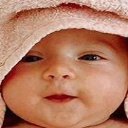

In [135]:
Image.fromarray(dataset_look[4196][0].astype('uint8'))

In [31]:
dataset_look[arg[0]][0].shape

(128, 128, 3)

In [137]:
all_to_del

2744

In [138]:
df = pd.read_csv(TRAIN_CSV_PATH, index_col=0)

In [156]:
names_to_del = df.reset_index().loc[all_to_del, 'name'].values

In [157]:
train_v4 = pd.read_csv('../ages_from_the_wild_true_cleared_stratify_reduced_train_v5.csv')
test_v4 = pd.read_csv('../ages_from_the_wild_true_cleared_stratify_reduced_test_v5.csv')

In [159]:
train_v4.shape

(256874, 60)

In [163]:
test_v4.shape

(28542, 60)

In [164]:
train_v4 = train_v4[~train_v4.name.isin(names_to_del)]
test_v4 = test_v4[~test_v4.name.isin(names_to_del)]

In [165]:
train_v4.shape

(255438, 60)

In [166]:
test_v4.shape

(28397, 60)

In [167]:
train_v4.to_csv('../ages_from_the_wild_true_cleared_stratify_reduced_train_v5.csv')
test_v4.to_csv('../ages_from_the_wild_true_cleared_stratify_reduced_test_v5.csv')

In [170]:
df[~df.name.isin(names_to_del)].to_csv(TRAIN_CSV_PATH)